Taken from https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

In [29]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
cluster = '2'
TRAIN_PATH = 'data/stage1_train_aug/cluster_' + cluster +'/'
TEST_PATH = 'data/stage1_test/'


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
%matplotlib inline

In [30]:
train_ids = os.listdir(TRAIN_PATH+'/images/')

In [31]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting train images and masks ... ')
for n in range(len(train_ids)):
    img = imread(TRAIN_PATH + '/images/image_' + str(n) + '.png')[:,:,:IMG_CHANNELS]
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask = np.expand_dims(imread(TRAIN_PATH + '/masks/mask_' + str(n) + '.png')[:,:],
                          axis=-1)
    Y_train[n] = mask

print('Done!')

Getting train images and masks ... 
Done!


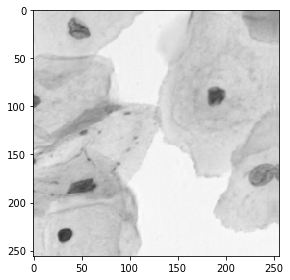

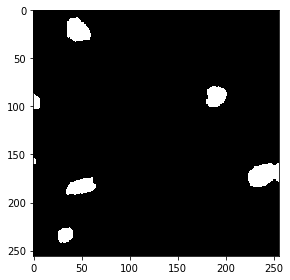

In [7]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [8]:
# Define IoU metric, according to kaggle this isnt correct
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [9]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c0 = Conv2D(8, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c0 = Dropout(0.1) (c0)
c0 = Conv2D(8, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c0)
p0 = MaxPooling2D((2, 2)) (c0)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p0)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

u10 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c9)
u10 = concatenate([u10, c0], axis=3)
c10 = Conv2D(8, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u10)
c10 = Dropout(0.1) (c10)
c10 = Conv2D(8, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c10)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c10)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  224         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 8)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [10]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-cluster-2-0.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=10, 
                    callbacks=[earlystopper, checkpointer])

Train on 2508 samples, validate on 279 samples
Epoch 1/10
2508/2508 [==============================] - 1350s 538ms/step - loss: 0.0823 - mean_iou: 0.4955 - val_loss: 0.0443 - val_mean_iou: 0.5679

Epoch 00001: val_loss improved from inf to 0.04431, saving model to model-cluster-2-0.h5
Epoch 2/10
2508/2508 [==============================] - 1345s 536ms/step - loss: 0.0259 - mean_iou: 0.6132 - val_loss: 0.0447 - val_mean_iou: 0.6412

Epoch 00002: val_loss did not improve
Epoch 3/10
2508/2508 [==============================] - 1345s 536ms/step - loss: 0.0222 - mean_iou: 0.6599 - val_loss: 0.0400 - val_mean_iou: 0.6748

Epoch 00003: val_loss improved from 0.04431 to 0.03999, saving model to model-cluster-2-0.h5
Epoch 4/10
2508/2508 [==============================] - 1345s 536ms/step - loss: 0.0182 - mean_iou: 0.6872 - val_loss: 0.0276 - val_mean_iou: 0.7004

Epoch 00004: val_loss improved from 0.03999 to 0.02763, saving model to model-cluster-2-0.h5
Epoch 5/10
2508/2508 [==================

In [19]:
# Predict on train, val and test
model = load_model('model-cluster-2-0.h5', custom_objects={'mean_iou': mean_iou})
#preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1, batch_size=16)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1,batch_size=16)
#preds_test = model.predict(X_test, verbose=1,batch_size=16)

# Threshold predictions
#preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
#preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
#preds_test_upsampled = []
#for i in range(len(preds_test)):
#    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
#                                       (sizes_test[i][0], sizes_test[i][1]), 
#                                       mode='constant', preserve_range=True))

279/279 [==============================] - 2s 9ms/step


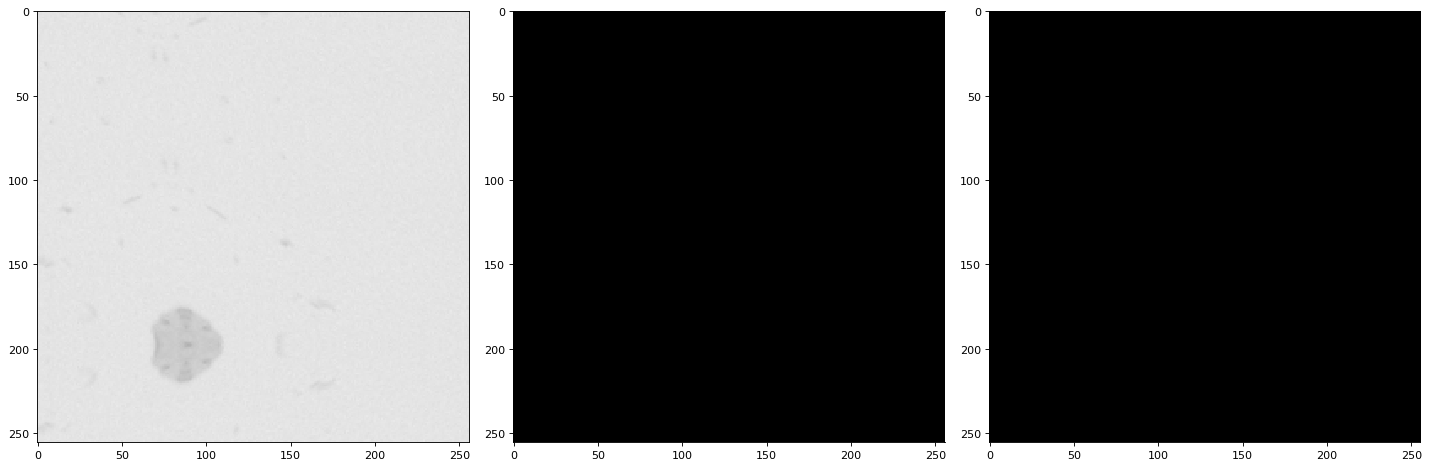

In [28]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_val_t))
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,3,1)
imshow(X_train[ix+int(X_train.shape[0]*0.9)])
plt.subplot(1,3,2)
imshow(np.squeeze(Y_train[ix+int(X_train.shape[0]*0.9)]))
plt.subplot(1,3,3)
imshow(np.squeeze(preds_val_t[ix]))
plt.show()